In [1]:
# امیرحسین هاشمی
# ۱۴۰۳/۰۴/۲۷

## چگونه ریسک را پوشش دهیم؟

### تشخیص ناهنجاری های بازار
#### تشخیص ناهنجاری‌های بازار برای اتخاذ تصمیمات صحیح بسیار مهم است. ناهنجاری‌ها در داده‌های سری زمانی می‌توانند نشان‌دهنده رویدادهای مهمی باشند، مانند سقوط یا رونق بازار، که می‌توانند تاثیر عمیقی بر استراتژی‌های سرمایه‌گذاری داشته باشند.

## مقدمه
##### تشخیص ناهنجاری‌ها در داده‌های سری زمانی یک وظیفه حیاتی در حوزه‌های مختلف است. در حیطه مالی تشخیص ناهنجاری‌ها می‌تواند به شناسایی رفتارهای غیرعادی بازار، مانند افزایش یا کاهش ناگهانی قیمت‌ها، که ممکن است نشان‌دهنده فرصت‌ها یا ریسک‌های احتمالی باشند، کمک کند. این آموزش بر استفاده از پایتون برای تشخیص ناهنجاری‌ها در داده‌های سری زمانی مالی، به‌ویژه قیمت رمزارزها، تمرکز خواهد کرد.


## راه‌اندازی محیط
#### ابتدا، بیایید کتابخانه‌های لازم را نصب کنیم.
#### yfinance: برای دانلود داده‌های مالی
#### numpy: برای عملیات روی داده‌ها
#### pandas: برای کار با داده‌ها
#### matplotlib, mplfinance: برای رسم نمودار
#### scikit-learn:‌ برای ایجاد الگوریتم های ماشین لرنینگ

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
from sklearn.ensemble import IsolationForest 
import plotly.graph_objects as go

/Users/amirosein/opt/anaconda3/envs/quera/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## دانلود داده‌های مالی
#### داده‌های تاریخی قیمت سه رمزارز را از ۱ ژانویه ۲۰۲۰ تا ۱۶ ژوئیه ۲۰۲۴ دانلود میکنیم

In [3]:
tickers = ['BTC-USD', 'ETH-USD', 'DOGE-USD']
start_date = '2020-01-01'
end_date = '2024-07-16'
data = {}
for ticker in tickers:
    ticker_data = yf.Ticker(ticker)
    df = ticker_data.history(start=start_date, end=end_date) 
    df['Ticker'] = ticker
    data[ticker] = df


## پاکسازی داده‌ها

#### قبل از اینکه به تشخیص ناهنجاری‌ها بپردازیم، بیایید داده‌ها را آماده کنیم. ما روی قیمت‌های پایانی تمرکز می‌کنیم و داده‌ها را به صورت هفتگی مرتب می‌کنیم تا نوسانات روزانه کمتر شوند.

In [5]:
def preprocess_data(data):
    processed_data = {}
    for ticker, df in data.items():
        df = df['Close'].resample('W').mean()
        processed_data[ticker] = df 
    return processed_data

processed_data = preprocess_data(data)

## مصورسازی داده‌ها
#### بیایید قیمت‌های پایانی ارزهای انتخاب شده را به تصویر بکشیم تا یک درک اولیه از داده‌ها به دست بیاوریم.

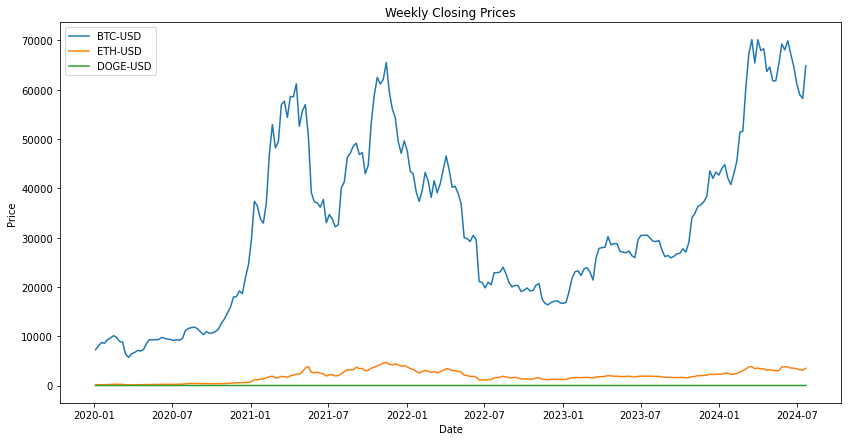

In [6]:
def plot_data(processed_data):
    plt.figure(figsize=(14, 7))
    for ticker, df in processed_data.items():
        plt.plot(df, label=ticker)
        plt.title('Weekly Closing Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()

plot_data(processed_data)

## Isolation Forest
#### یک الگوریتم محبوب برای تشخیص ناهنجاری‌ها است که با داده‌های سری زمانی به خوبی کار می‌کند. این الگوریتم با انتخاب تصادفی یک ویژگی و سپس انتخاب تصادفی یک مقدار تقسیم بین مقادیر حداکثر و حداقل ویژگی انتخاب شده، مشاهدات را ایزوله می‌کند.







In [7]:
class AnomalyDetector:
    def __init__(self, contamination=0.05):
        self.contamination = contamination
        self.model = IsolationForest(contamination=self.contamination)

    def fit(self, data):
        self.data = pd.DataFrame(data)  # Ensure data is a DataFrame
        self.model.fit(self.data.values.reshape(-1, 1))

    def detect_anomalies(self):
        self.data['anomaly'] = self.model.predict(self.data.values.reshape(-1, 1))
        self.data['anomaly'] = self.data['anomaly'].apply(lambda x: 1 if x == -1 else 0)
        return self.data

# Assuming processed_data is a dictionary where keys are tickers and values are dataframes
detectors = {}
for ticker, df in processed_data.items():
    detector = AnomalyDetector()
    detector.fit(df)
    detectors[ticker] = detector.detect_anomalies()

## نمایش ناهنجاری‌ها
#### بیایید ناهنجاری‌های شناسایی شده را روی نمودارهای قیمت سهام به تصویر بکشیم.

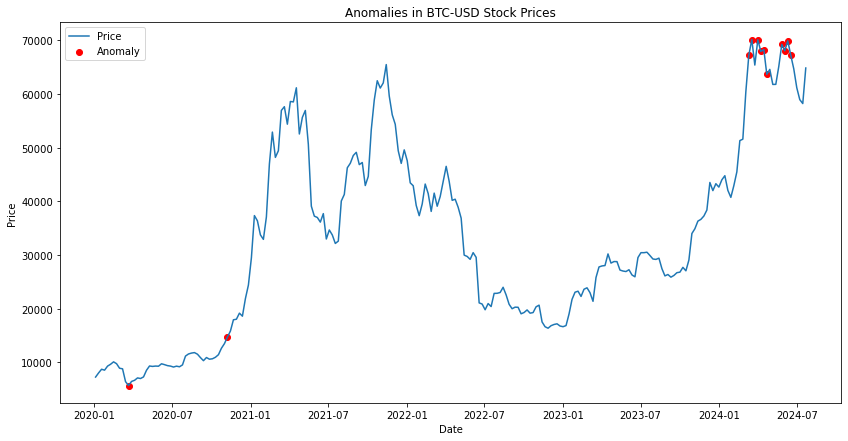

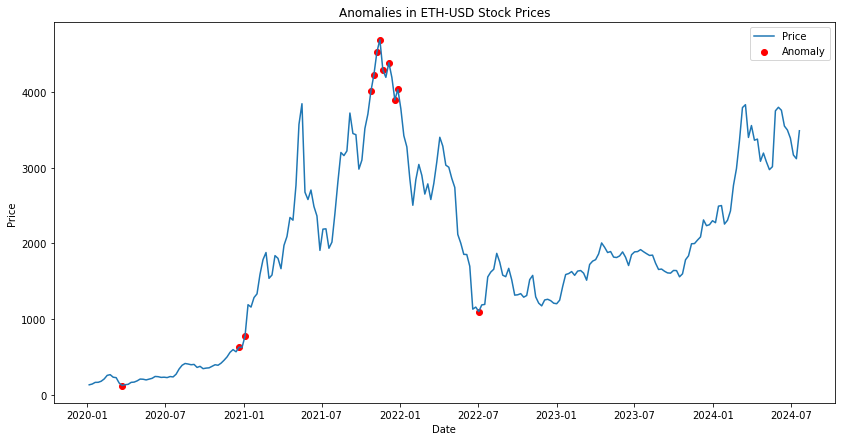

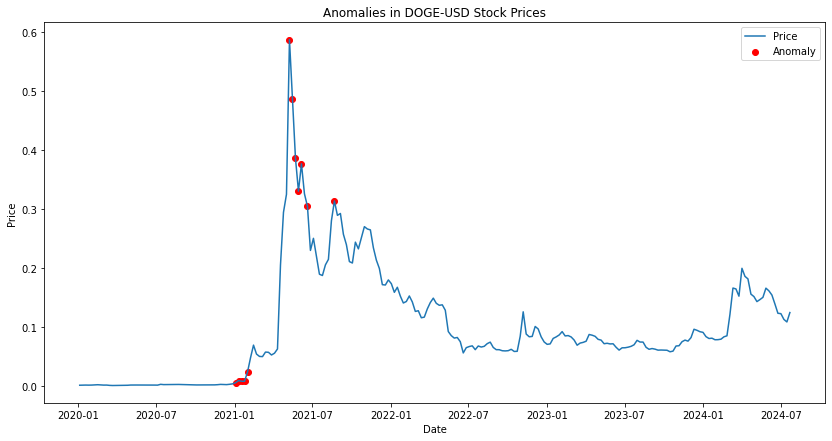

In [10]:

def plot_anomalies(detectors):
    for ticker, df in detectors.items():
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df.iloc[:, 0], label='Price')
        anomalies = df[df['anomaly'] == 1]
        plt.scatter(anomalies.index, anomalies.iloc[:, 0], color='red', label='Anomaly')
        plt.title(f'Anomalies in {ticker} Stock Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

# Assuming `detectors` is a dictionary with ticker symbols as keys and DataFrames as values
plot_anomalies(detectors)

## نتیجه‌گیری
 #### در این آموزش یاد گرفتیم چطور با استفاده از پایتون ناهنجاری‌ها را در داده‌های سری زمانی پیدا کنیم. ما از کتابخانه یاهو برای دانلود داده‌های واقعی مالی استفاده کردیم و یک سیستم تشخیص ناهنجاری باایزولیتد فارست الگوریتم ساختیم. با نمایش ناهنجاری‌های شناسایی شده روی نمودار، توانستیم رفتارهای غیرعادی بازار را شناسایی کنیم که می‌تواند نشان‌دهنده فرصت‌ها یا ریسک‌های احتمالی باشد. تشخیص ناهنجاری ابزاری قوی در بخش مالی است که به سرمایه‌گذاران و تحلیل‌گران کمک می‌کند تصمیمات بهتری بگیرند. با استفاده از پایتون و الگوریتم‌های یادگیری ماشین، می‌توانیم سیستم‌های قوی برای تشخیص و تحلیل ناهنجاری‌ها در داده‌های مالی بسازیم. امیدواریم این آموزش به شما یک پایه محکم برای استفاده از تکنیک‌های تشخیص ناهنجاری در پروژه‌های تحلیل داده‌های مالی‌تان داده باشد.
